This notebook will query/join Gaia and PS1 to get g,r,i,z,y photometry for bright stars. We'll put the query part in this notebook and develop another notebook to make the plots. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from astroquery.gaia import Gaia 


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [4]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [5]:
for table in tables:
    print(table.get_qualified_name())

external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_config.tap_config.properties
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiaedr3.gaiaedr3.gaia_source
gaiaedr3.gaiaedr3.agn_cross_id
gaiaedr3.gaiaedr3.commanded_scan_law
gaiaedr3.gaiaedr3.dr2_neighbourhood
gaiaedr3.gaiaedr3.frame_rotator_source
gaiaedr3.gaiaedr3.hipparcos2_best_neighbour
gaiaedr3.gaiaedr

In [6]:
meta=Gaia.load_table('gaiaedr3.gaia_source') 

Retrieving table 'gaiaedr3.gaia_source'
Parsing table 'gaiaedr3.gaia_source'...
Done.


In [7]:
print(meta)

TAP Table name: gaiaedr3.gaiaedr3.gaia_source
Description: This table has an entry for every Gaia observed source as listed in the
Main Database accumulating catalogue version from which the catalogue
release has been generated. It contains the basic source parameters,
that is only final data (no epoch data) and no spectra (neither final
nor epoch).
Num. columns: 99


In [8]:
for column in meta.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [9]:
meta2=Gaia.load_table('gaiaedr3.panstarrs1_join')
for column in meta2.columns:
    print(column.name)

Retrieving table 'gaiaedr3.panstarrs1_join'
Parsing table 'gaiaedr3.panstarrs1_join'...
Done.
original_ext_source_id
clean_panstarrs1_oid


In [10]:
meta3=Gaia.load_table('gaiadr2.panstarrs1_original_valid')
for column in meta3.columns:
    print(column.name)

Retrieving table 'gaiadr2.panstarrs1_original_valid'
Parsing table 'gaiadr2.panstarrs1_original_valid'...
Done.
obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


In [12]:
# set limits for query
min_parallax_ratio = 20
min_brightness = 12
how_many = 30000
#dec<0 is hardcoded right now. No ra limit but could add

In [13]:
query_edr3_base="""select TOP {how_many}
  gaiaedr3.gaia_source.source_id,
  gaiaedr3.gaia_source.ra,
  gaiaedr3.gaia_source.dec,
  gaiaedr3.gaia_source.parallax,
  gaiaedr3.gaia_source.parallax_over_error,
  gaiaedr3.gaia_source.phot_g_mean_mag,
  gaiaedr3.gaia_source.bp_rp,
  gaiaedr3.gaia_source.l,
  gaiaedr3.gaia_source.b,
  ps.g_mean_psf_mag,
  ps.r_mean_psf_mag,
  ps.i_mean_psf_mag,
  ps.z_mean_psf_mag,
  ps.y_mean_psf_mag
from gaiaedr3.gaia_source 
-- panstarrs
join gaiaedr3.panstarrs1_best_neighbour
  on gaiaedr3.panstarrs1_best_neighbour.source_id=gaiaedr3.gaia_source.source_id
join gaiadr2.panstarrs1_original_valid as ps
  on ps.obj_id = gaiaedr3.panstarrs1_best_neighbour.original_ext_source_id
WHERE
 gaiaedr3.gaia_source.parallax_over_error > {min_error} and
 gaiaedr3.gaia_source.dec < 0 and
 gaiaedr3.gaia_source.phot_g_mean_mag > {min_brightness}
  """



In [14]:
query_edr3 = query_edr3_base.format(how_many=how_many,min_brightness=min_brightness,min_error=min_parallax_ratio)

In [15]:
print(query_edr3)

select TOP 30000
  gaiaedr3.gaia_source.source_id,
  gaiaedr3.gaia_source.ra,
  gaiaedr3.gaia_source.dec,
  gaiaedr3.gaia_source.parallax,
  gaiaedr3.gaia_source.parallax_over_error,
  gaiaedr3.gaia_source.phot_g_mean_mag,
  gaiaedr3.gaia_source.bp_rp,
  gaiaedr3.gaia_source.l,
  gaiaedr3.gaia_source.b,
  ps.g_mean_psf_mag,
  ps.r_mean_psf_mag,
  ps.i_mean_psf_mag,
  ps.z_mean_psf_mag,
  ps.y_mean_psf_mag
from gaiaedr3.gaia_source 
-- panstarrs
join gaiaedr3.panstarrs1_best_neighbour
  on gaiaedr3.panstarrs1_best_neighbour.source_id=gaiaedr3.gaia_source.source_id
join gaiadr2.panstarrs1_original_valid as ps
  on ps.obj_id = gaiaedr3.panstarrs1_best_neighbour.original_ext_source_id
WHERE
 gaiaedr3.gaia_source.parallax_over_error > 20 and
 gaiaedr3.gaia_source.dec < 0 and
 gaiaedr3.gaia_source.phot_g_mean_mag > 12
  


In [16]:
job  = Gaia.launch_job_async(query_edr3)


INFO: Query finished. [astroquery.utils.tap.core]


In [17]:
results=job.get_results()

In [18]:
results

source_id,ra,dec,parallax,parallax_over_error,phot_g_mean_mag,bp_rp,l,b,g_mean_psf_mag,r_mean_psf_mag,i_mean_psf_mag,z_mean_psf_mag,y_mean_psf_mag
,deg,deg,mas,,mag,mag,deg,deg,,mag,mag,mag,mag
int64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
4063470555986293632,268.2722690750943,-27.840792649974965,0.8603942336373175,20.000006,16.057327,1.2159605,1.7844034336897427,-0.8451794430770536,16.7359008789063,16.0431003570557,15.7800998687744,15.6681995391846,15.5841999053955
4075924930328092928,279.156157491139,-26.245544915444775,1.8075668270434355,20.000006,16.76521,2.018447,7.794098821232397,-8.631934819903805,18.2322006225586,16.8859004974365,16.1949996948242,15.8035001754761,15.5785999298096
5736155980334693376,137.33281517932804,-11.695644712582691,1.1258811864223772,20.000008,16.370586,1.4076071,241.14813245685508,23.632003038318526,17.2577991485596,16.3339996337891,15.9682998657227,15.8284997940063,15.7175998687744
4079718584693480832,281.1446628064845,-21.726908891576173,0.8128454435085273,20.00001,15.855675,1.2226267,12.704906587571381,-8.282666418301567,16.5265998840332,15.8746995925903,15.5675001144409,15.3905000686646,15.3156003952026
5476197758984671488,156.37795558859148,-20.571890828222948,0.5840077552092299,20.000011,14.805334,0.83087826,262.6147472007607,30.64631846206042,15.1787004470825,14.7915000915527,14.6577997207642,14.6284999847412,14.5935001373291
5716198229391345920,113.8214208677862,-20.653171160371315,0.6647400808633399,20.000013,15.652907,1.0306778,236.20070004584394,-0.14147387478536877,16.1961994171143,15.6356000900269,15.4328002929688,15.3416996002197,15.266900062561
2894901622152885888,97.39404455278382,-30.21888530039131,2.3017506434995245,20.000015,18.379047,2.644125,238.43852257995,-17.62266090242924,20.2187004089355,18.9563999176025,17.6756000518799,17.0820007324219,16.7618007659912
3068522861893067008,119.21343737767813,-4.485354724321476,0.6693719410958845,20.000015,15.70902,0.9461336,224.60300015563956,12.366661573075092,16.1590003967285,15.6730003356934,15.5088996887207,15.4518995285034,15.4010000228882


In [19]:
outname_base='LSST-Gaia-PS1-{min_brightness}-{min_error}-{how_many}.fits'

In [21]:
outname=outname_base.format(min_brightness=min_brightness,min_error=min_parallax_ratio,how_many=how_many)

In [22]:
print(outname)

LSST-Gaia-PS1-12-20-30000.fits


In [23]:
results.write(outname, overwrite=True)

That's it. The next notebook will read this file (or others!) and make the plots. 

But let's make one plot to check

Text(0, 0.5, 'dec (deg ICRS)')

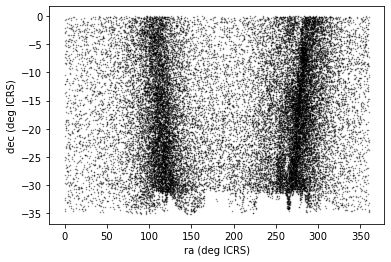

In [24]:
ra=results['ra']
dec=results['dec']

plt.plot(ra,dec, 'ko',alpha=0.5,markersize=0.5)
plt.xlabel('ra (deg ICRS)')
plt.ylabel('dec (deg ICRS)')